<a href="https://colab.research.google.com/github/Charliebond125/Classification_Driver_Behaviour/blob/main/Classification_Driver_Behaviour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Perform classification using different algorithms. 
KNN, SVM, Random Forest, Tensorflow.
EDA is very important. Ensure justification for approach is used.
Training and validation datasets.

List of Tasks:-

- Import required libraries to use in Classification
- Identify PreProcessing steps
- Exploratory Data Analysis to identify features
- Data Engineering and Feature Extraction
- Identify Hypothesis and Null Hypothesis
- Seperate each class, remove noise and assign train/test set. 
- Perform dimensionality reduction, experimenting with both Standard Scaler, Robust Scaler (https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) (2008, Laurens van der Maaten, Geoffrey Hinton)
- Convert categorical values using Label Encoding
- REcombine each data class
- Feed new data into pipeline to perform classification across range of classifiers
- Use RandomsearchCV to find best parameters
- perform hyperparemeter tuning

To add, this dataset is a multi-label classification problem. The three classes, 'Normal', 'Aggressive', or 'Defensive', are to be predicted and attained from training data in the first instance.

Using supervised learning on the split training data, 

In [2]:
# importing required libraries

""" Phase One """

import os
import re
import math

import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster, datasets, metrics
sns.set()
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [3]:
""" Reading data from github repo which I uploaded with train data """

url_train = 'https://raw.githubusercontent.com/Charliebond125/Classification_Driver_Behaviour/main/train_motion_data.csv'
url_test = 'https://raw.githubusercontent.com/Charliebond125/Classification_Driver_Behaviour/main/test_motion_data.csv'
dataframe = pd.read_csv(url_train)
print(dataframe.sample(5))

test_data = pd.read_csv(url_test)

          AccX      AccY      AccZ     GyroX     GyroY     GyroZ       Class  \
2920  0.101571  0.226346 -0.269423 -0.046884  0.080023  0.023137        SLOW   
1683 -0.595047  0.972569  0.038140 -0.009621 -0.007941 -0.001298  AGGRESSIVE   
516  -1.150449  0.191138 -1.339638  0.000153 -0.211359 -0.097815      NORMAL   
3575 -0.709695  0.146160 -0.450915  0.051465  0.113621 -0.029398        SLOW   
1399  0.269693  0.256495 -0.260439  0.016035  0.061087  0.061621  AGGRESSIVE   

      Timestamp  
2920    3583401  
1683    3582627  
516     3581908  
3575    3583755  
1399    3582473  


<h1> Phase 1: Reading and Visualising Data <h1>

<p2> Using Pandas to visualise, calculate null values, shape, and determine important features through exploratory analysis. 

In [4]:
dataframe.shape

(3644, 8)

In [5]:
dataframe.head()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,NORMAL,3581629
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,NORMAL,3581630
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,NORMAL,3581630
3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,NORMAL,3581631
4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,NORMAL,3581631


In [6]:
print(dataframe.columns.tolist())

['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Class', 'Timestamp']


In [7]:
print(dataframe.describe().T)

train_data = dataframe

            count          mean         std           min           25%  \
AccX       3644.0  4.046692e-02    0.985653 -4.636523e+00 -5.506954e-01   
AccY       3644.0 -7.341815e-02    0.903408 -4.699795e+00 -5.925396e-01   
AccZ       3644.0  8.271386e-03    0.985061 -7.143998e+00 -5.584636e-01   
GyroX      3644.0  1.592709e-03    0.066918 -7.518224e-01 -2.855795e-02   
GyroY      3644.0 -1.273027e-03    0.126205 -1.587028e+00 -5.375614e-02   
GyroZ      3644.0  7.949043e-03    0.115687 -1.236468e+00 -2.939789e-02   
Timestamp  3644.0  3.582707e+06  642.147947  3.581629e+06  3.582121e+06   

                    50%           75%           max  
AccX       3.931045e-03  5.959871e-01  4.985548e+00  
AccY      -8.083267e-02  4.524008e-01  4.245151e+00  
AccZ       2.261639e-03  5.561569e-01  5.171739e+00  
GyroX      1.985312e-03  3.191771e-02  8.492554e-01  
GyroY     -1.832596e-03  5.131268e-02  1.679879e+00  
GyroZ      2.977968e-03  4.085161e-02  1.190500e+00  
Timestamp  3.582702e+

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3644 entries, 0 to 3643
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AccX       3644 non-null   float64
 1   AccY       3644 non-null   float64
 2   AccZ       3644 non-null   float64
 3   GyroX      3644 non-null   float64
 4   GyroY      3644 non-null   float64
 5   GyroZ      3644 non-null   float64
 6   Class      3644 non-null   object 
 7   Timestamp  3644 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 227.9+ KB


In [9]:
train_data.corr()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Timestamp
AccX,1.000000,0.207575,-0.044951,-0.099053,0.041181,-0.316195,0.040371
AccY,0.207575,1.000000,0.041521,-0.018746,0.004012,-0.041036,0.005101
AccZ,-0.044951,0.041521,1.000000,-0.042200,-0.012598,0.078577,-0.009431
GyroX,-0.099053,-0.018746,-0.042200,1.000000,0.209730,0.228621,-0.002978
GyroY,0.041181,0.004012,-0.012598,0.209730,1.000000,0.154064,0.005673
GyroZ,-0.316195,-0.041036,0.078577,0.228621,0.154064,1.000000,-0.031176
Timestamp,0.040371,0.005101,-0.009431,-0.002978,0.005673,-0.031176,1.000000


In [10]:
train_data.isnull().sum()

AccX         0
AccY         0
AccZ         0
GyroX        0
GyroY        0
GyroZ        0
Class        0
Timestamp    0
dtype: int64

In [11]:
print(train_data.groupby('Class').size())

Class
AGGRESSIVE    1113
NORMAL        1200
SLOW          1331
dtype: int64


In [12]:
train_data['Class'].unique()

array(['NORMAL', 'AGGRESSIVE', 'SLOW'], dtype=object)

#<h2> Visualisation of Features <h2>

<p1> Using pyplot and seaborn libraries to visualize the feature variables which will most influence our data. With this we can see when it comes to testing our train data against our validation sets which has the most influence on train/test accuracy.

The goal is to use ROC score as a accuracy benchmark.

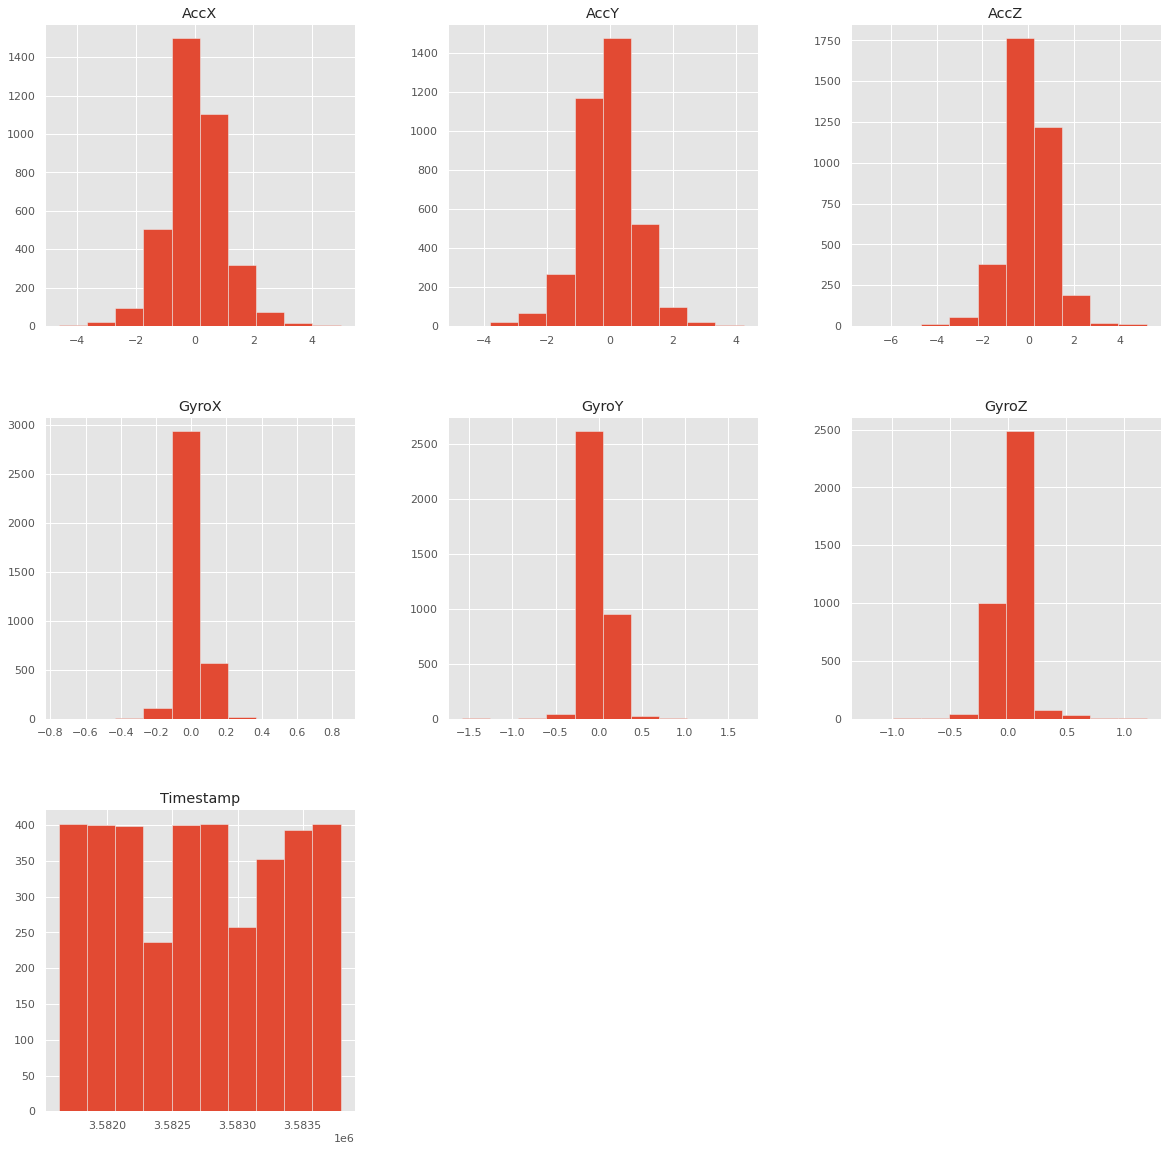

In [13]:
p_hist = train_data.hist(figsize = (20,20))

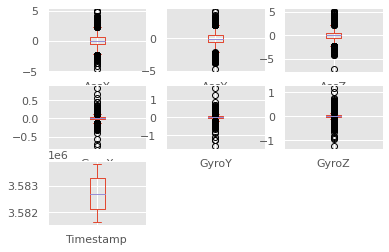

In [14]:
train_data.plot(kind='box', subplots=True, layout=(3,3))
pyplot.show()

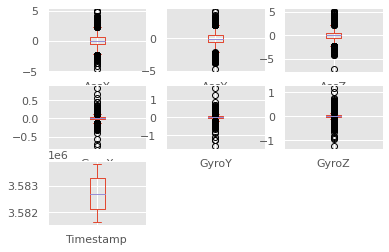

In [15]:
train_data.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)
pyplot.show()

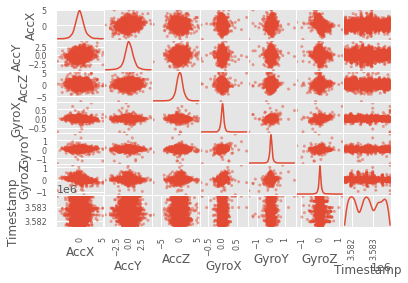

In [16]:
scatter_matrix(train_data, diagonal='kde')
plt.show()

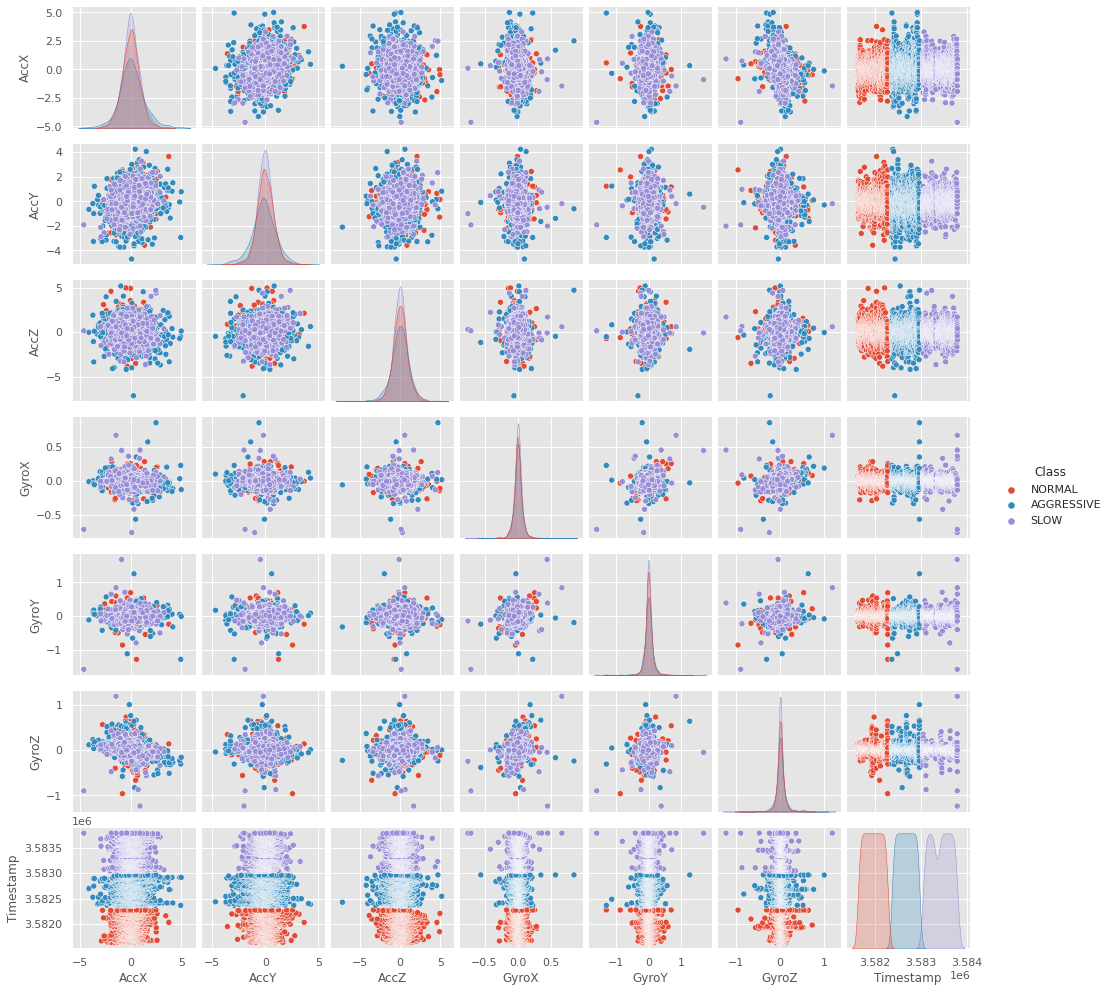

In [17]:
sns.pairplot(train_data, hue='Class', size=2)

<h1> Gaussian Distribution of Each Label. <h1>

<p1/> When folded over the top of each other, the bell shaped curve becomes very obvious. This indicates a Gaussian Distribution, but it also needs to be scaled to the mean and unit variance of standard deviation. We can also see from the bottom right plot that the data blends to each other, creating noise between the classes. <p1/>

In [18]:
# Need to create a noise loss function either using LOSS or a kalman filter due to road


#Normalization of data and noise reduction

In [19]:
# normalizing data to be one type

numerical_data_float64 = (train_data.dtypes == "float64")
numerical_data_float64_list = list(numerical_data_float64[numerical_data_float64].index)

print("Numerical variables:")
print(numerical_data_float64_list)

numerical_data_int64 = (train_data.dtypes == "int64")
numerical_data_int64_list = list(numerical_data_int64[numerical_data_int64].index)

print("Numerical variables:")
print(numerical_data_int64_list)

Numerical variables:
['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
Numerical variables:
['Timestamp']


In [20]:
""" 
As seen in the visualization, timestamp gives an opportunity for the models to overfit
each row is unique and so it will train to look just for the timestamp. This needs to be removed later on.

I have identified 6 features in our list, 'AccX','AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ'.

There is also 3 labels, 'SLOW', AGGRESSIVE', 'NORMAL'.

One indication of time series to be used in identifying different driving behaviours across the recorded time is, 'Timestamp' which is recorded in seconds, as int64.

Identifying the number of records to drop allows the data to be even, and removes noise.

"""

# Identifying the global constants.
FEATURES = 6
LABELS = 3
# Records to drop from head and tail of dataset because of noise reason
N_RECORDS = 11 

In [21]:
""" Split the samples by class so it can be trimmed to a desired shape
    and reduce identified noise between classes

"""
train_data_normal = train_data.loc[train_data['Class'] == 'NORMAL']
train_data_slow = train_data.loc[train_data['Class'] == 'SLOW']
train_data_aggressive = train_data.loc[train_data['Class'] == 'AGGRESSIVE']

test_data_normal = test_data.loc[test_data['Class'] == 'NORMAL']
test_data_slow = test_data.loc[test_data['Class'] == 'SLOW']
test_data_aggressive = test_data.loc[test_data['Class'] == 'AGGRESSIVE']

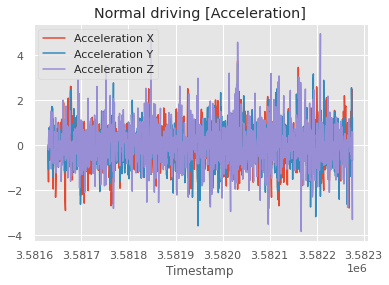

In [22]:
import matplotlib.pyplot as plt

plt.plot(train_data_normal['Timestamp'], train_data_normal['AccX'], label='Acceleration X')
plt.plot(train_data_normal['Timestamp'], train_data_normal['AccY'], label='Acceleration Y')
plt.plot(train_data_normal['Timestamp'], train_data_normal['AccZ'], label='Acceleration Z')

plt.title('Normal driving [Acceleration]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

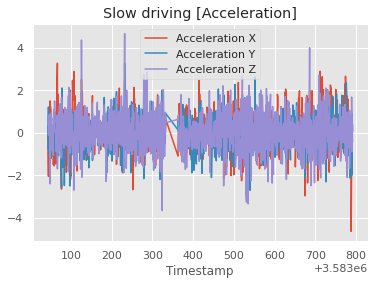

In [23]:
# Slow driving behavior's acceleration
import matplotlib.pyplot as plt

plt.plot(train_data_slow['Timestamp'], train_data_slow['AccX'], label='Acceleration X')
plt.plot(train_data_slow['Timestamp'], train_data_slow['AccY'], label='Acceleration Y')
plt.plot(train_data_slow['Timestamp'], train_data_slow['AccZ'], label='Acceleration Z')

plt.title('Slow driving [Acceleration]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

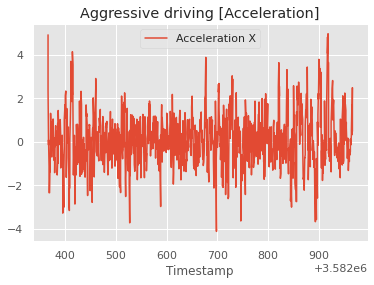

In [24]:
import matplotlib.pyplot as plt

print(plt.plot(train_data_aggressive['Timestamp'], train_data_aggressive['AccX'], label='Acceleration X'))

plt.title('Aggressive driving [Acceleration]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

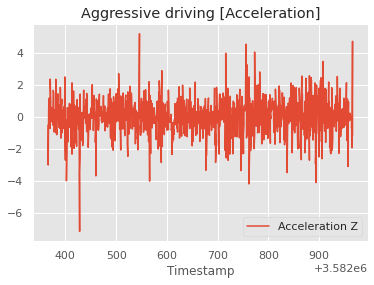

In [25]:
print(plt.plot(train_data_aggressive['Timestamp'], train_data_aggressive['AccZ'], label='Acceleration Z'))

plt.title('Aggressive driving [Acceleration]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

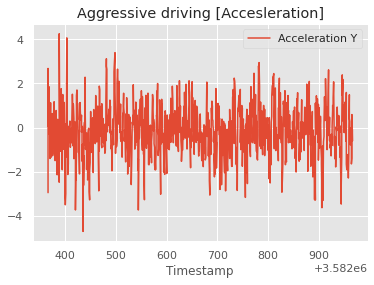

In [26]:
print(plt.plot(train_data_aggressive['Timestamp'], train_data_aggressive['AccY'], label='Acceleration Y'))

plt.title('Aggressive driving [Accesleration]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

<h2> Deciding which method to use <h2> 

<p2> The best method as given above would be to remove Timestamp as a feature variable, as each row allows the models to overfit on the data. As each class is mismatched in terms of quantity, I need to use a method to take samples from each class to produce the desired train and test set.

The data needs to be normalized, and ensurewhen creating the train/test set we take equal pairings.

In [27]:
train_data_slow = train_data_slow.iloc[N_RECORDS:]
train_data_slow = train_data_slow.iloc[:-N_RECORDS]

test_data_slow = test_data_slow.iloc[N_RECORDS:]
test_data_slow = test_data_slow.iloc[:-N_RECORDS]

train_data_normal = train_data_normal.iloc[N_RECORDS:]
train_data_normal = train_data_normal.iloc[:-N_RECORDS]

test_normal = test_data_normal.iloc[N_RECORDS:]
test_normal = test_data_normal.iloc[:-N_RECORDS]

train_data_aggressive = train_data_aggressive.iloc[N_RECORDS:]
train_data_aggressive = train_data_aggressive.iloc[:-N_RECORDS]

test_data_aggressive = test_data_aggressive.iloc[N_RECORDS:]
test_data_aggressive = test_data_aggressive.iloc[:-N_RECORDS]

In [28]:
train_slow_samples = train_data_slow.__len__()
train_normal_samples = train_data_normal.__len__()
train_aggressive_samples = train_data_aggressive.__len__()

print('---Train---')
print('Slow samples: ' + str(train_slow_samples))
print('Normal samples: ' + str(train_normal_samples))
print('Aggressive samples: ' + str(train_aggressive_samples))

train_data_slow = train_data_slow.tail(1300)
train_data_normal = train_data_normal.tail(1160)
train_data_aggressive = train_data_aggressive.tail(1080)

---Train---
Slow samples: 1309
Normal samples: 1178
Aggressive samples: 1091


In [29]:
test_slow_samples = test_data_slow.__len__()
test_normal_samples = test_data_normal.__len__()
test_aggressive_samples = test_data_aggressive.__len__()

print('---Test---')
print('Slow samples: ' + str(test_slow_samples))
print('Normal samples: ' + str(test_normal_samples))
print('Aggressive samples: ' + str(test_aggressive_samples))

df_test_slow = test_data_slow.tail(1240)
df_test_normal = test_data_normal.tail(960)
df_test_aggressive = test_data_aggressive.tail(780)

---Test---
Slow samples: 1251
Normal samples: 997
Aggressive samples: 792


In [30]:
# Separating features from labels

# Features
X_train_normal = train_data_normal.iloc[: , :FEATURES]
X_train_slow = train_data_slow.iloc[: , :FEATURES]
X_train_aggressive = train_data_aggressive.iloc[: , :FEATURES]

X_test_normal = df_test_normal.iloc[: , :FEATURES]
X_test_slow = df_test_slow.iloc[: , :FEATURES]
X_test_aggressive = df_test_aggressive.iloc[: , :FEATURES]

# Labels
y_train_normal = train_data_normal.Class
y_train_slow = train_data_slow.Class
y_train_aggressive = train_data_aggressive.Class

y_test_normal = df_test_normal.Class
y_test_slow = df_test_slow.Class
y_test_aggressive = df_test_aggressive.Class

# Timestamp

X_train_normal_time = train_data_normal.Timestamp
X_train_slow_time = train_data_slow.Timestamp
X_train_aggressive_time = train_data_aggressive.Timestamp

X_test_normal_time = df_test_normal.Timestamp
X_test_slow_time = df_test_slow.Timestamp
X_test_aggressive_time = df_test_aggressive.Timestamp

print(X_train_normal_time)
print(X_test_normal_time)

29      3581645
30      3581645
31      3581646
32      3581646
33      3581647
         ...   
1184    3582268
1185    3582269
1186    3582269
1187    3582270
1188    3582271
Name: Timestamp, Length: 1160, dtype: int64
851     819460
852     819460
853     819461
854     819462
855     819462
         ...  
1806    819976
1807    819976
1808    819977
1809    819977
1810    819978
Name: Timestamp, Length: 960, dtype: int64


In [31]:
# Combine all the samples into training datasets
X_train = pd.concat([X_train_normal, X_train_aggressive, X_train_slow])
y_train = pd.concat([y_train_normal, y_train_aggressive, y_train_slow])

X_test = pd.concat([X_test_normal, X_test_aggressive, X_test_slow])
y_test = pd.concat([y_test_normal, y_test_aggressive, y_test_slow])

In [32]:
# As ML/DL algorithms are working with numbers
# the labels should be mapped to numbers on the y axis

""" Assigning Class feature as binary method using LabelEncoder 

    Normal = 1
    Slow = 2
    Aggressive = 3
    
"""

from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

In [33]:
print(X_train)

          AccX      AccY      AccZ     GyroX     GyroY     GyroZ
29   -0.744453  0.308070  0.134162 -0.002902  0.059865  0.004200
30   -2.311000 -0.000236  1.234169  0.013592 -0.145386 -0.044670
31   -1.235491 -1.186430 -0.450856 -0.000458  0.058032 -0.017181
32   -0.057978 -1.254435 -1.226808 -0.029780  0.015272  0.031689
33    0.735135 -0.594205  0.560677  0.009927 -0.021991 -0.016570
...        ...       ...       ...       ...       ...       ...
3628 -0.449011 -1.084056 -0.597144 -0.002902 -0.015272  0.034743
3629 -0.719420 -0.698871  1.062971 -0.054825 -0.029932  0.114155
3630 -0.616803 -0.926785 -1.661728 -0.004734  0.055589  0.170355
3631 -0.543381 -2.121441  0.827515  0.043524 -0.156382  0.048182
3632  0.702303 -0.930822  0.809290  0.001985 -0.172264 -0.025733

[3540 rows x 6 columns]


In [34]:
# As the dataset contains variables that are different in scale,
# a good solution will be to standardize it
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [35]:
# Using stratifiedkfold as classes are unbalanced, with shuffle set to true.

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True)
df_train = skf.get_n_splits(X_train, y_train)
df_test = skf.get_n_splits(X_test, y_test)

In [36]:
# Shuffle data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [37]:
# Understanding shape of our train and test data after performing skfold

""" This is to ensure we are working with data that
    is the same shape in both our test and train sets """

print("Shape of X_train: " + str(X_train.shape))
print("Shape of y_train: " + str(y_train.shape))
print("shape of X_test: " + str(X_test.shape))
print("Shape of y_test: " + str(y_test.shape))

Shape of X_train: (3540, 6)
Shape of y_train: (3540,)
shape of X_test: (2980, 6)
Shape of y_test: (2980,)


In [38]:
# Checking the shape of our ndarray

print(X_train[5])

[ 1.07685954 -0.27790594  1.88530494  0.1010857  -1.5648602  -0.91941669]


In [39]:
# Ensuring our labelencoder has worked as expected in converting catagorical features to numerical

print(y_train[:100])

[1 1 0 2 0 0 2 0 1 1 2 0 2 2 2 2 0 1 2 2 2 0 1 2 2 0 1 0 0 1 1 2 0 2 2 1 1
 2 0 1 2 1 0 1 0 1 1 1 2 1 2 2 0 1 0 1 1 2 1 2 0 2 1 2 2 2 1 2 0 2 1 1 2 1
 0 1 2 2 2 1 0 1 2 1 0 0 2 0 1 1 1 0 2 0 2 0 0 0 2 0]


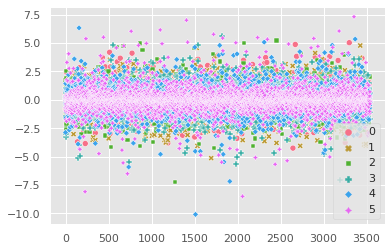

In [40]:
# Visualising all 6 features across a scatter plot
# This gives an idea for the value of time of each feature

train_plot = pd.DataFrame(X_train)
sns.scatterplot(data=train_plot, palette='husl')

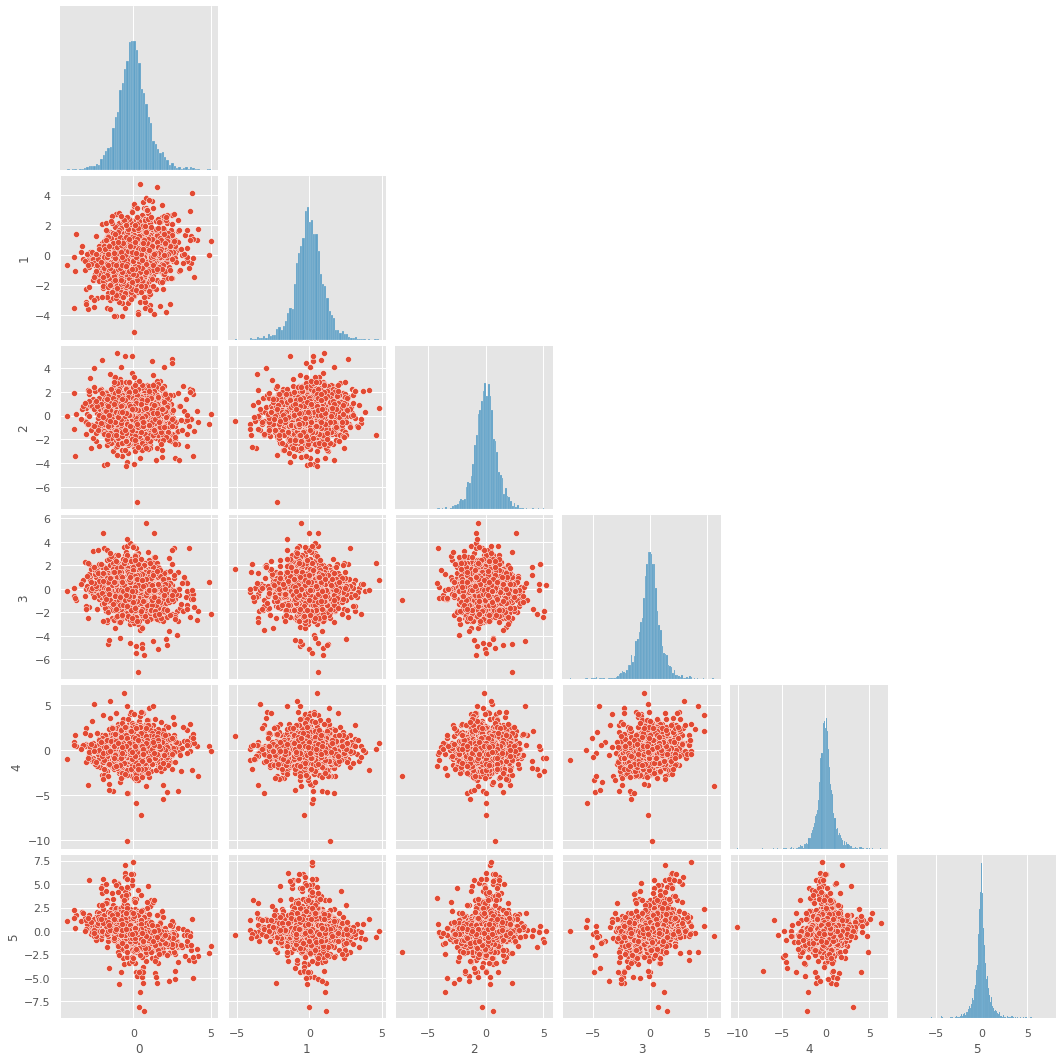

In [41]:
# scaled_x = pd.DataFrame(data=X_tsne)
# sns.pairplot(scaled_x)

train_plot = pd.DataFrame(data=X_train)
sns.pairplot(train_plot, palette='husl', diag_kind="hist", corner=True)

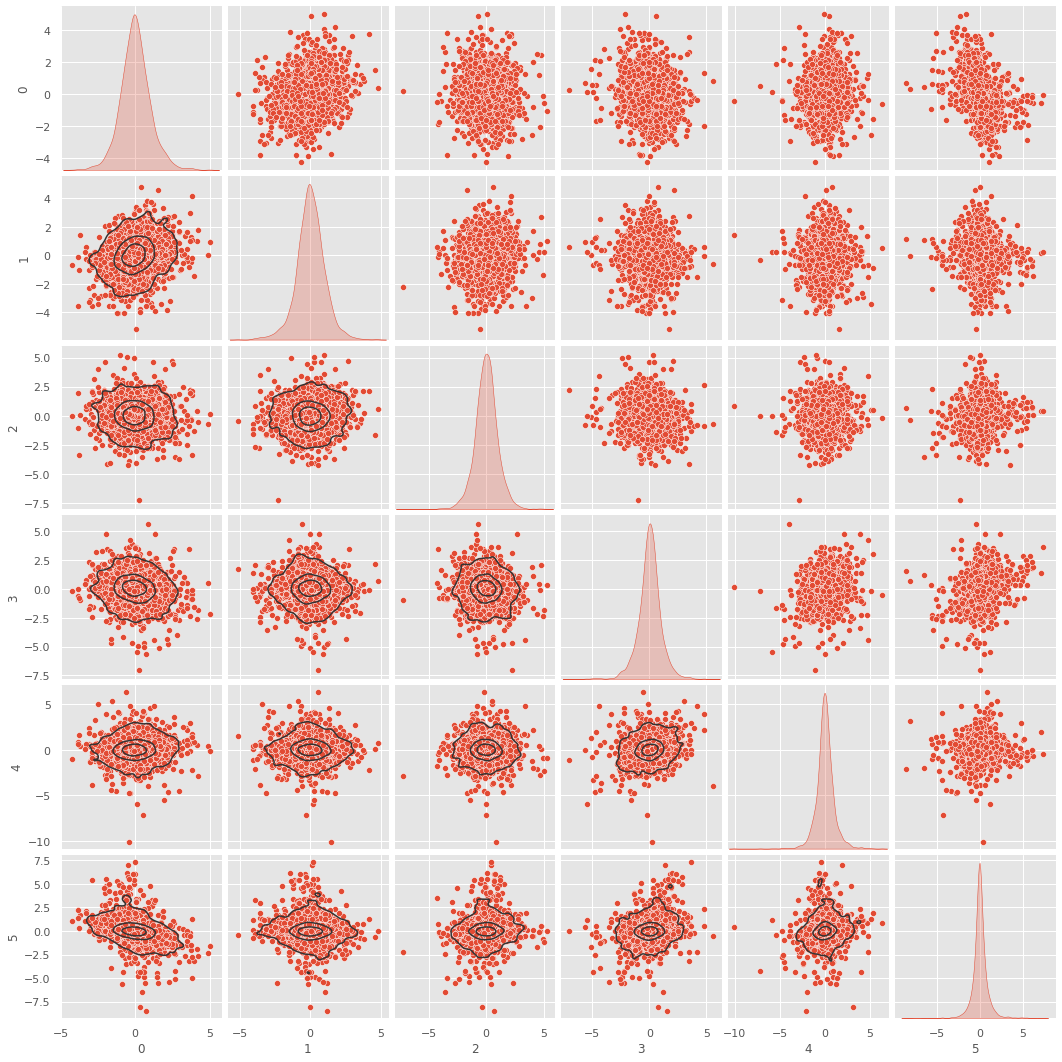

In [42]:
X_train_plot = pd.DataFrame(data=X_train)
g = sns.pairplot(X_train_plot, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

# Now here we can see the clusters of all three classes. 
# PCA and KernelPCA have no effect 
# on finding the optimal distance between each class

<h1> Creating Pipeline <h1>

After converting our catagorical column into numerical (int64), this will be better suited to variety of machine learning models to perform classification.

I've decided it will be better to produce a pipeline to preprocess and normalize the data, then feed this into a set of classifiers.

Once this is done, I will then perform Cross Validation using GridSearchCV and RandomSearchCV to find the best parameters for each classifier.

From this, I can then look to see which we can tune and what hyperparemeters will give the best result.

# Creation of Pipeline

In [43]:
from sklearn.preprocessing import QuantileTransformer

# Creating a basic pipeline with LogisticRegression to gain a baseline
# we will also use this opportunity to see if any other transformation 
# will assist in model performance.

pipeline_1 = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('clf', LogisticRegression()) #step2 - classifier
])
print(pipeline_1.steps)

[('normalizer', StandardScaler()), ('clf', LogisticRegression())]


In [44]:
from sklearn.model_selection import cross_validate

scores_1 = cross_validate(pipeline_1, X_train, y_train, return_train_score=True, return_estimator=True)

print(scores_1)

{'fit_time': array([0.03069544, 0.02335906, 0.02572799, 0.0251689 , 0.01542187]), 'score_time': array([0.00113583, 0.00108647, 0.00439692, 0.00071573, 0.00074458]), 'estimator': [Pipeline(steps=[('normalizer', StandardScaler()),
                ('clf', LogisticRegression())]), Pipeline(steps=[('normalizer', StandardScaler()),
                ('clf', LogisticRegression())]), Pipeline(steps=[('normalizer', StandardScaler()),
                ('clf', LogisticRegression())]), Pipeline(steps=[('normalizer', StandardScaler()),
                ('clf', LogisticRegression())]), Pipeline(steps=[('normalizer', StandardScaler()),
                ('clf', LogisticRegression())])], 'test_score': array([0.40112994, 0.42231638, 0.3799435 , 0.38983051, 0.38841808]), 'train_score': array([0.40007062, 0.40254237, 0.41137006, 0.40536723, 0.40748588])}


In [45]:
print(scores_1['test_score'].mean())

0.39632768361581927


In [46]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from matplotlib.colors import ListedColormap

names = [
    "Support Vector Classifier",
    "LogisticRegression",
    "RBF SVM",
    "KNeighborsClassifier",
    "DecisionTreeClassifier",
    "RandomForestClassifier",
    "GradientBoostingClassifier",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

clfs = []

clfs.append(LogisticRegression())
clfs.append(SVC())
clfs.append(KNeighborsClassifier())
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier())
clfs.append(GradientBoostingClassifier())
clfs.append(AdaBoostClassifier())
clfs.append(GaussianNB())
clfs.append(MLPClassifier())
clfs.append(GaussianProcessClassifier())


for classifier in clfs:
    pipeline_1.set_params(clf = classifier)
    scores = cross_validate(pipeline_1, X_train, y_train, return_train_score = True)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())

---------------------------------
LogisticRegression()
-----------------------------------
fit_time  mean  0.01576519012451172
fit_time  std  0.0008697444540122218
score_time  mean  0.0007898807525634766
score_time  std  5.6113422033172836e-05
test_score  mean  0.39632768361581927
test_score  std  0.014640292112824792
train_score  mean  0.4053672316384181
train_score  std  0.0039129647393206304
---------------------------------
SVC()
-----------------------------------
fit_time  mean  0.5634331226348877
fit_time  std  0.012123836176580338
score_time  mean  0.12100028991699219
score_time  std  0.003237866063589132
test_score  mean  0.4310734463276836
test_score  std  0.015712919757258043
train_score  mean  0.5093220338983051
train_score  std  0.007459178489554189
---------------------------------
KNeighborsClassifier()
-----------------------------------
fit_time  mean  0.004289817810058594
fit_time  std  0.0002707411260257734
score_time  mean  0.046266937255859376
score_time  std  0.02

In [62]:
from sklearn.model_selection import GridSearchCV
  
# Create list of hyperparameters 
max_iter = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
hidden_layer_sizes = [(8, ), (16, ), (24,),(30,),(40,),(50,),(60,),(70,),(80,),(90,),(100,)]
learning_rate = ('constant', 'inviscaling', 'adaptive')
solver = ('adam', 'lbfgs', 'sgd')
activation = ('relu', 'tanh', 'logistic')
param_grid = {'max_iter': max_iter,
              'hidden_layer_sizes': hidden_layer_sizes,
              'learning_rate': learning_rate,
              'solver': solver,
              'activation': activation }

# Use Grid search CV to find best parameters using 4 jobs
pipeline_1.set_params(clf=MLPClassifier())
mlp = MLPClassifier()
clf = GridSearchCV(estimator = mlp, param_grid = param_grid, n_jobs = -1)
clf.fit(X_train, y_train)
print("Best Score: ")
print(clf.best_score_)
print("Best Estimator: ")
print(clf.best_estimator_)
# #mlp_clf = 

print(pipeline_1)

# param_grid = [
#     {
        
#     'max__iter': [10, 20],
#     'hidden__layer__sizes': [(10,), (20,), (30,)],
# }

# param_grid = [
#     {'max_iter': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#     'hidden_layer_sizes': [(10,),(20,),(30,)(40,),(50,),(60,),(70,),(80,),(90,),(100,)],
#     "solver": "adam", "learning_rate_init": 0.01},
# ]


# clf = GridSearchCV(pipeline_1, param_grid)

# clf.fit(X_train, y_train)

# print(
#     cv_grid.best_params_,
#     cv_grid.best_estimator_,
#     cv_grid.best_score_
# )

Best Score: 
0.4451977401129944
Best Estimator: 
MLPClassifier(hidden_layer_sizes=(8,), max_iter=20, solver='lbfgs')
Pipeline(steps=[('normalizer', StandardScaler()), ('clf', MLPClassifier())])


In [64]:
pipeline_1.set_params(clf=MLPClassifier(hidden_layer_sizes=(8,), max_iter=20, solver='lbfgs'))

Pipeline(steps=[('normalizer', StandardScaler()),
                ('clf',
                 MLPClassifier(hidden_layer_sizes=(8,), max_iter=20,
                               solver='lbfgs'))])

In [72]:
clf_2 = pipeline_1.fit(X_train, y_train)

In [73]:
clf_2 = pipeline_1.predict(X_test)

In [76]:
accuracy_test = accuracy_score(y_test, clf_2)
print('Accuracy of the best classifier after CV is %.3f%%' % (accuracy_test*100))

Accuracy of the best classifier after CV is 45.772%


In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf_2))

              precision    recall  f1-score   support

           0       0.43      0.43      0.43       780
           1       0.36      0.17      0.23       960
           2       0.50      0.70      0.58      1240

    accuracy                           0.46      2980
   macro avg       0.43      0.43      0.41      2980
weighted avg       0.43      0.46      0.43      2980



In [50]:
pipeline_1.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'normalizer', 'clf', 'normalizer__copy', 'normalizer__with_mean', 'normalizer__with_std', 'clf__activation', 'clf__alpha', 'clf__batch_size', 'clf__beta_1', 'clf__beta_2', 'clf__early_stopping', 'clf__epsilon', 'clf__hidden_layer_sizes', 'clf__learning_rate', 'clf__learning_rate_init', 'clf__max_fun', 'clf__max_iter', 'clf__momentum', 'clf__n_iter_no_change', 'clf__nesterovs_momentum', 'clf__power_t', 'clf__random_state', 'clf__shuffle', 'clf__solver', 'clf__tol', 'clf__validation_fraction', 'clf__verbose', 'clf__warm_start'])

In [71]:
y_predict_1 = clf.predict(X_test)
accuracy_1 = accuracy_score(y_test,y_predict_1)
print('Accuracy of the best classifier after CV is %.3f%%' % (accuracy_1*100))

Accuracy of the best classifier after CV is 44.732%
